# Implementation of a Double Deep Q-Network for the training of a model agent that learns to play Connect4

### Installing the needed library for the enviroment simulation

In [1]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1
!pip install ipython==7.10.0 > /dev/null 2>&1 # getting warning with latest version of ipython, go to 7.10 to get rid of it (optional)

### Importing useful libraries for the plotting, enviroment and training of our model
- numpy : working with numerical data
- tqdm : progress bar for training
- matplotlib : plotting measurement results
- gym : reinforcement learning API
- kaggle_enviromentes : game environment
- torch : machine learning framework

In [2]:
import numpy as np
from tqdm.notebook import tqdm     # progress bar
import matplotlib.pyplot as plt    # plotting

# Model and ConnectX Enviroment
import gym
from kaggle_environments import evaluate, make

# Model for neural network
import torch
import torch.nn as nn
import torch.optim as optim

#### Check if the system supports for CUDA (GPU computation) tensor types or CPU tensors.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Making an object for the training enviroment of our agent
### Attributes:
- env : kaggle enviroment
- config : enviroment configuration
- action_space : space of actions for the board
- observation_space : observation space, rows x columns
- pair : training pair
- trainer : current trainer
- switch_prob : switch side probability

### Methods:
- switch_side : switch the side that our agent is in (to learn for both)
- reset : reset after every game, for new one
- step : accessing observations, rewards, status done or not, and information
- render : state rendering
- switch_trainer : switching trainer
        

In [4]:
# class for the training enviroment
class ConnectX(gym.Env):
    def __init__(self, switch_prob = 0.5):

        self.env = make('connectx', debug = False)
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

        # initializing the other player to be the random bot
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

    # method for switching the side of our agent
    def switch_side(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    # method for switching side every time we reset
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_side()
        return self.trainer.reset()

    # method for accessing observations, rewards, status done or not, and information
    def step(self, action):
        return self.trainer.step(action)

    # method for rendering state
    def render(self, **kwargs):
        return self.env.render(**kwargs)

    # method for switching trainer from random to negamax (pro kaggle player)
    def switch_trainer(self):
        current_trainer_random = 'random' in self.pair
        if current_trainer_random:
            self.pair = [None, 'negamax']
        else:
            self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)

## Making an object for the model and the Double Deep Q-Network that the agent model will be trained in.

 Our network takes as input the state of the environment, later the training network proposes which action appears best and the Q-value of this selected action is evaluated by the target network

 The code for training our model, the train() method of our DQN class is a single step of the policy optimization.  

In [6]:
# class for our model
class DeepModel(nn.Module):
    def __init__(self, num_states, hidden_units, num_actions):
        super(DeepModel, self).__init__()
        self.layers = []
        input_dim = num_states
        for hidden in hidden_units:
            self.layers.append(nn.Linear(input_dim, hidden))
            self.layers.append(nn.ReLU())  # Activation function
            input_dim = hidden
        self.layers.append(nn.Linear(hidden_units[-1], num_actions))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

# class for our Deeq Q Network
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):

        self.num_actions = num_actions   # number of actions + 1 (6x7)+1 = 43
        self.gamma = gamma               # 0.99

        self.batch_size = batch_size     # batch size for experience replay
        self.experience = {'s' : [], 'a' : [], 'r' : [], 's2' : [], 'done' : []} # experience replay
        self.max_experiences = max_experiences # experience replay size
        self.min_experiences = min_experiences # minimum experience replay size before training

        self.model = DeepModel(num_states, hidden_units, num_actions) # model
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr) # optimizer
        self.criterion = nn.MSELoss()                                 # loss

    # append experience to the buffer is, if the buffer is full pop the oldest one
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    # train the agent
    def train(self, TargetNet):

        # don't train before the reaching the minimum experience replay size
        if len(self.experience['s']) < self.min_experiences:
            return 0

        # Random sample batches from experience replay buffer
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)

        # Get the states from the samples of the experience bufferand preprocess them.
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])

        actions = np.asarray([self.experience['a'][i] for i in ids])  # Retrieve the actions
        rewards = np.asarray([self.experience['r'][i] for i in ids])  # Retrieve the rewards

        # Get the next states from the samples of the experience bufferand preprocess them.
        next_states = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids]) # Retrieve the 'done' flags

        # Calculate the maximum Q-value for the next states using the target network.
        value_next = np.max(TargetNet.predict(next_states).detach().numpy(), axis = 1)
        # Compute the actual Q-values using the Bellman equation.
        actual_values = np.where(dones, rewards, rewards + self.gamma * value_next)

        # Make the actions table into tensor input like
        actions = np.expand_dims(actions, axis = 1)
        actions_one_hot = torch.FloatTensor(self.batch_size, self.num_actions).zero_()
        actions_one_hot = actions_one_hot.scatter_(1, torch.LongTensor(actions), 1)

        # Calculate the Q-values for the actions taken using the current Q-network.
        selected_action_values = torch.sum(self.predict(states) * actions_one_hot, dim = 1)
        actual_values = torch.FloatTensor(actual_values)

        # Reset gradients before performing a backward pass.
        self.optimizer.zero_grad()
        # Compute the loss between the predicted Q-values and the actual Q-values
        loss = self.criterion(selected_action_values, actual_values)
        loss.backward()           # backpropagation
        self.optimizer.step()     # update weights  networ

    def copy_weights(self, TrainNet):
        self.model.load_state_dict(TrainNet.model.state_dict())

    def save_weights(self, path):
        torch.save({'model':self.model.state_dict(),'optimizer':self.optimizer.state_dict()}, path)

    def load_weights(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])

    # function to preprocess state before packaging
    def preprocess(self, state):
      result = state['board'][:]
      result.append(state['mark'])
      return result

    # function for prediction
    def predict(self, inputs):
        return self.model(torch.from_numpy(inputs).float())

    # function to get the next action of our model
    def get_action(self, state, epsilon):
        # if we explore select a random available column
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state['board'][c] == 0]))

        prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].detach().numpy()
        for i in range(self.num_actions):
            if state['board'][i] != 0 :
                prediction[i] = -1e7
        # return the column with largest predicted Q value
        return int(np.argmax(prediction))

    # check if our last action prevented a connect4 from the opponent
    def check_prevention(self, board, last_action, player):
      rows, cols = board.shape
      opponent = 1 if player == 2 else 2

      # get the row of the last action
      for row in range(rows):
        if board[row, last_action] != 0:
            break
      prevented = False

      board[row, last_action] = opponent
      prevented = self.is_winner(board, opponent)
      board[row, last_action] = player  # Replace the piece

      return prevented

    # function that checks if a player is a winner in the given board state
    def is_winner(self, board, player):
      rows, cols = board.shape
      # Horizontal check
      for r in range(rows):
          for c in range(cols - 3):
              if board[r, c] == player and board[r, c+1] == player and board[r, c+2] == player and board[r, c+3] == player:
                  return True
      # Vertical check
      for r in range(rows - 3):
          for c in range(cols):
              if board[r, c] == player and board[r+1, c] == player and board[r+2, c] == player and board[r+3, c] == player:
                  return True
      # Diagonal check
      for r in range(3, rows):
          for c in range(cols - 3):
              if board[r, c] == player and board[r-1, c+1] == player and board[r-2, c+2] == player and board[r-3, c+3] == player:
                  return True
      for r in range(rows - 3):
          for c in range(cols - 3):
              if board[r, c] == player and board[r+1, c+1] == player and board[r+2, c+2] == player and board[r+3, c+3] == player:
                  return True

      return False

## Game simulation loop
The play_game function simulates a single game loop of the Connect4 game. In a while loop we get the action the training net would choose for a given game state and then we simulate that action in the enviroment. Then, the enviroment returns the next state of the board (observations), if the game ended (done) and the outcome of the game if it ended (reward).

If the game ended depending on the outcome we update the reward they get for the game that they played. If the game did not finish we check whether our move prevented the opponent from scoring a Connect4, if so reward the agent. Lastly, we encourage our player to play for longer (not lose too fast).

Then at the end of each training loop we store the experiences to the replay buffer and train the model.

In [7]:
def play_game(env, TrainNet, TargetNet, epsilon, wins, reward_cookies, current_episode, episode_update):
    rewards = 0
    done = False
    observations = env.reset()

    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        #print(f"Current Board: \n{np.array(observations['board']).reshape((6, 7))}")
        if done:
          if reward == 1:   # win
            wins += 1
            reward = reward_cookies['win']
          elif reward == 0: # lose
            reward = reward_cookies['lose']
          else:             # draw
            reward = reward_cookies['draw']

        else:
          didPrevent = TrainNet.check_prevention(np.array(observations['board']).reshape((6,7)), action, observations['mark'])
          if didPrevent:
            reward = reward_cookies['prevented']  # Give a small reward for preventing a win

            #print(f"Just prevented, I am {observations['mark']}")
            # print(f"\nBoard: \n{np.array(observations['board']).reshape((6, 7))}")

          # make our agent try to play for longer (as long as the game is not over he gets a reward of 0.5)
          # but a threshold must be created so that if it has passed a certain limit the agent will try to win (not try to play longer)
          if rewards <= 2.5:
              reward += 0.5
          else:
              reward -= 0.5
        rewards += reward

        # create game memory buffer
        exp = {'s' : prev_observations, 'a' : action, 'r' : reward, 's2' : observations, 'done' : done}
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)

        # copy the weights from our train network to our targetNetwork every <copy_step> (25) episodes
        if current_episode % episode_update == 0 and current_episode != 0:
          TargetNet.copy_weights(TrainNet)
    return rewards, wins

## Hyperparameters and utilities
### This cell instantiates hyperparameters, and defines some utilities about the reward system.

- gamma : discount factor as mentioned in the previous section
- hidden_units : hidden layers of our network
- max_experiences : size of the replay buffer
- min_experiences : amount of experiences stored before training the model
- batch_size : number of transitions sampled from the replay buffer
- lr : learning rate of the Adam optimizer
- epsilon: starting value of epsilon  
- decay : the rate of exponential decay of epsilon
- min_epsilon : final value of epsilon
- random_episodes : number of episodes we train against the random agent
- negamax_episodes : number of episodes we train against the negamax agent  
- reward_cookies_random : reward dictionary for training against random agent
- reward_cookies_negamax : reward dictionary for training against negamax agent

In [8]:
env = ConnectX() # initialize the environment

# set hyperparameters
gamma = 0.99
hidden_units = [100, 200, 200, 100]
max_experiences = 17500
min_experiences = 100
batch_size = 32
lr = 0.001
epsilon = 1.0
decay = 0.995
min_epsilon = 0.05
random_episodes = 20000
negamax_episodes = 7500

reward_cookies_random = {
    'win' : 25,
    'lose' : -50,
    'draw' : 0,
    'prevented' : 15
}

reward_cookies_negamax = {
    'win' : 75,
    'lose' : -25,
    'draw' : 15,
    'prevented' : 15
}

#### Initialization of the two Deep Q-Networks,
- num_states : number of states for the input of our DQNs
- num_actions : number of actions, the output of our DQNs
- all_total_rewards(_negamax) : total rewards for training with random agent (with negamax)
- all_avg_rewards(_negamax)  : average reward over the last 100 episodes against random agent(with negamax)
- all_epsilons(_negamax) : exploration rate decay (with negamax)
- win_perc(_negamax) : win percentage against random agent (with negamax)
- TrainNet : training DQN for action selection
- TargetNet : target DQN for action evaluation

In [9]:
num_states = env.observation_space.n + 1
num_actions = env.action_space.n

all_total_rewards = np.empty(random_episodes)
all_avg_rewards = np.empty(random_episodes)
all_epsilons = np.empty(random_episodes)
win_perc = np.empty(random_episodes)

all_total_rewards_negamax = np.empty(negamax_episodes)
all_avg_rewards_negamax = np.empty(negamax_episodes)
all_epsilons_negamax = np.empty(negamax_episodes)
win_perc_negamax = np.empty(negamax_episodes)

TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)

Code for loading weights of a pretrained agent to our current agent.

In [ ]:
filepath = "weights.pth"
TrainNet.load_weights(filepath)

# Training loop
Below is the training loop used to train for random_episodes against the random agent and later trained against the negamax agent for negamax_episodes (experienced agent of the kaggle enviroment), where during the training we also keep track of the win percentage, average reward of the last 100 episodes and epsilon decay.

In [ ]:
print(f"For {random_episodes} random episodes.\n Now training with {env.pair}")
progress_bar = tqdm(range(random_episodes))
wins = 0
episode_update = 50
for i in progress_bar:

    if i % 10 == 0: # every 10 episodes epsilon decay
        epsilon = max(min_epsilon, epsilon * decay)
    else:
        epsilon = max(min_epsilon, epsilon)

    total_reward, wins = play_game(env, TrainNet, TargetNet, epsilon, wins, reward_cookies_random, i, episode_update)
    all_total_rewards[i] = total_reward
    avg_reward = all_total_rewards[max(0, i-100) : (i+1)].mean()
    all_avg_rewards[i] = avg_reward
    all_epsilons[i] = epsilon
    current_win_perc = (wins/(i+1))*100
    win_perc[i] = current_win_perc

    progress_bar.set_postfix({
        'episode_reward' : total_reward,
        'avg of last 100 reward' : avg_reward,
        'epsilon' : epsilon,
        'wins' : wins,
        'win perc' : f"{current_win_perc:.2f}%"
    })
from datetime import datetime
filename = f'./weights_{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}_random.pth'
TrainNet.save_weights(filename)

from google.colab import files
files.download(filename)

For 20000 random episodes.
 Now training with [None, 'random']


  0%|          | 0/20000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

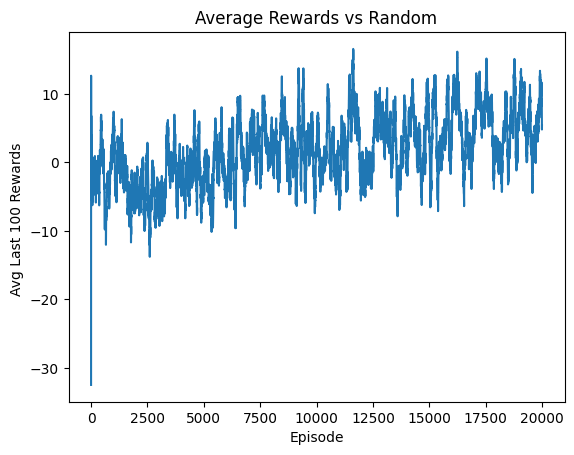

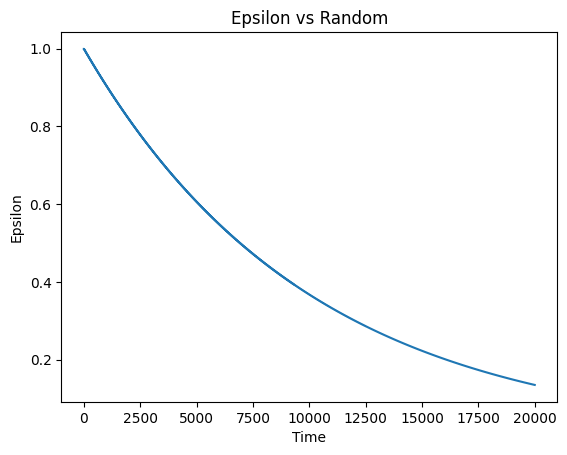

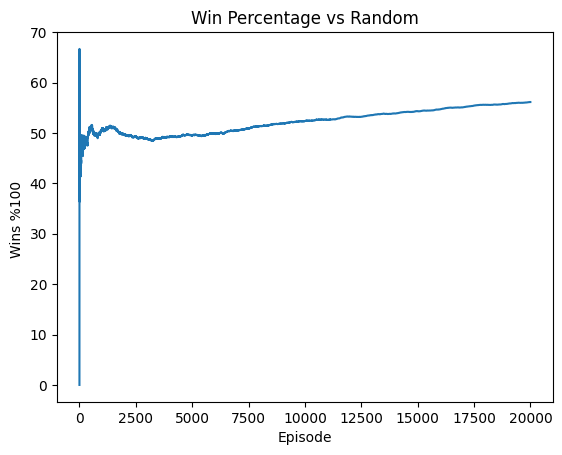

In [ ]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg Last 100 Rewards ')
plt.title('Average Rewards vs Random')
plt.show()

plt.plot(all_epsilons)
plt.xlabel('Time')
plt.ylabel('Epsilon')
plt.title('Epsilon vs Random')
plt.show()

plt.plot(win_perc)
plt.title("Win Percentage vs Random")
plt.xlabel('Episode')
plt.ylabel('Wins %100 ')
plt.show()

In [ ]:
# reset some hyperparameters
epsilon = 1.0
decay = 0.995
episode_update = 25
wins = 0
progress_bar = tqdm(range(negamax_episodes))
env.switch_trainer()
print(f"For {negamax_episodes} negamax episodes.\n Now training with {env.pair}")
for i in progress_bar:

    if i % 10 == 0: # every 10 episodes epsilon decay
        epsilon = max(min_epsilon, epsilon * decay)
    else:
        epsilon = max(min_epsilon, epsilon)

    total_reward, wins = play_game(env, TrainNet, TargetNet, epsilon, wins, reward_cookies_negamax, i, episode_update)
    all_total_rewards_negamax[i] = total_reward
    avg_reward = all_total_rewards_negamax[max(0, i-100) : (i+1)].mean()
    all_avg_rewards_negamax[i] = avg_reward
    all_epsilons_negamax[i] = epsilon
    current_win_perc = (wins/(i+1))*100
    win_perc_negamax[i] = current_win_perc

    progress_bar.set_postfix({
        'episode_reward' : total_reward,
        'avg of last 100 reward' : avg_reward,
        'epsilon' : epsilon,
        'wins' : wins,
        'win perc' : f"{current_win_perc:.2f}%"
    })
from datetime import datetime
filename = f'./weights_{datetime.now().strftime("%d_%m_%Y_%H_%M_%S_")}_final.pth'
TrainNet.save_weights(filename)

from google.colab import files
files.download(filename)

  0%|          | 0/7500 [00:00<?, ?it/s]

For 7500 negamax episodes.
 Now training with [None, 'negamax']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plotting results
We plot the results for the measurements we kept during the training of our agent against both opponent agents, expecting that our agent would have a harder time against the more experienced one but still learn over time and develop a strategy.

In [ ]:
plt.plot(all_avg_rewards_negamax)
plt.xlabel('Episode')
plt.ylabel('Avg Last 100 Rewards ')
plt.title('Average Rewards vs Negamax')
plt.show()

plt.plot(all_epsilons_negamax)
plt.xlabel('Time')
plt.ylabel('Epsilon')
plt.title('Epsilon vs Negamax')
plt.show()

plt.plot(win_perc_negamax)
plt.title("Win Percentage vs Negamax")
plt.xlabel('Episode')
plt.ylabel('Wins %100 ')
plt.show()

Show winrate with random agent

In [ ]:
env.switch_trainer()
print(env.pair)
progress_bar = tqdm(range(100))
wins = 0
episode_update = 50
for i in progress_bar:

    total_reward, wins = play_game(env, TrainNet, TargetNet, epsilon, wins, reward_cookies_random, i, episode_update)
    avg_reward = all_total_rewards[max(0, i-100) : (i+1)].mean()
    current_win_perc = (wins/(i+1))*100

    progress_bar.set_postfix({
        'episode_reward' : total_reward,
        'avg of last 100 reward' : avg_reward,
        'epsilon' : epsilon,
        'wins' : wins,
        'win perc' : f"{current_win_perc:.2f}%"
    })

Show winrate with negamax agent

In [ ]:
env.switch_trainer()
print(env.pair)
progress_bar = tqdm(range(100))
wins = 0
episode_update = 50
for i in progress_bar:

    total_reward, wins = play_game(env, TrainNet, TargetNet, epsilon, wins, reward_cookies_random, i, episode_update)
    avg_reward = all_total_rewards[max(0, i-100) : (i+1)].mean()
    current_win_perc = (wins/(i+1))*100

    progress_bar.set_postfix({
        'episode_reward' : total_reward,
        'avg of last 100 reward' : avg_reward,
        'epsilon' : epsilon,
        'wins' : wins,
        'win perc' : f"{current_win_perc:.2f}%"
    })

Code for making the submission file for kaggle evaluation feature of our agent.

In [13]:
filepath = "/content/weights.pth"
TrainNet.load_weights(filepath)

In [22]:
fc_layers = []

for i in range(len(TrainNet.model.layers)-1):
    if i % 2 == 1:
      continue
    fc_layers.extend([
        TrainNet.model.layers[i].weight.T.tolist(),
        TrainNet.model.layers[i].bias.tolist()
    ])
fc_layers.extend([
    TrainNet.model.layers[-1].weight.T.tolist(),
    TrainNet.model.layers[-1].bias.tolist()
])

fc_layers = list(map(
    lambda x: str(list(np.round(x, 7))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', ''),
    fc_layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation['board'][:]
    state.append(observation['mark'])
    out = np.array(state, dtype=np.float32)

'''

for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = np.maximum(out,0)\n'

my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

my_agent += '''
    for i in range(configuration['columns']):
        if observation['board'][i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''
with open('submission.py', 'w') as f:
    f.write(my_agent)

[[[1.1109405755996704, -0.9938812851905823, -0.09725303947925568, -0.4864426255226135, 1.40541672706604, -0.770805835723877, -1.085824966430664, -0.14204750955104828, 0.8729883432388306, -0.2329816371202469, 1.0067138671875, 0.48897862434387207, -0.1895742565393448, -0.5874089002609253, 0.007209854666143656, -0.4798731207847595, -0.7923446297645569, 0.09306967258453369, -0.7690560817718506, -3.5228168964385986, 0.11434616893529892, -0.1559455245733261, 0.3811188042163849, -0.3458307087421417, 1.1458823680877686, 0.3835572302341461, -1.5320470333099365, -0.2370733916759491, 0.4351264536380768, 0.37982824444770813, -0.25885382294654846, -0.7376996278762817, -1.3066591024398804, -2.07612681388855, 0.2632158100605011, 1.2446588277816772, 0.03259635344147682, 0.04654315486550331, -0.4740547239780426, -1.028704285621643, 2.256765127182007, 0.9545127153396606, 0.531670093536377, 0.6261419653892517, -0.6484991312026978, -0.93818199634552, 0.3186062276363373, 1.5972471237182617, -0.769711732864

Agent evaluation

In [24]:
from submission import my_agent

env = make("connectx", debug=True)
env.run([my_agent, my_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=50)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=50)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

Success!
My Agent vs. Random Agent: 0.82
Random Agent vs. My Agent: 0.3
My Agent vs. Negamax Agent: 0.0
Negamax Agent vs. My Agent: 1.0
